In [2]:
pip install transformers pytorch-pretrained-bert

     |████████████████████████████████| 573kB 7.6MB/s 
     |████████████████████████████████| 133kB 19.0MB/s 
     |████████████████████████████████| 870kB 20.1MB/s 
     |████████████████████████████████| 3.7MB 44.5MB/s 
     |████████████████████████████████| 1.0MB 32.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=362cda9f75b1b53c5c424dabfb4bfbc7e3a92262d364cb650f6676091af7008a
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [3]:
import torch 

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
from transformers import BertForSequenceClassification, AdamW
from pytorch_pretrained_bert import BertTokenizer

# Reload the saved model and vocabulary
print('Reloading the saved model and vocabulary...')

TRAINED_MIGRANTS_BERT = './drive/My Drive/Colab Notebooks/Bert models/LabBert_migrants_english/'

model = BertForSequenceClassification.from_pretrained(TRAINED_MIGRANTS_BERT)
tokenizer = BertTokenizer.from_pretrained(TRAINED_MIGRANTS_BERT, do_lower_case=False)

# Tell the model to run on the GPU
model.cuda()

optimizer = AdamW(model.parameters(), 
                lr=2e-5, # learning rate, default = 5e-5
                eps=1e-8 # adam_epsilon, default = 1e-8
                )

print('Done...')

Reloading the saved model and vocabulary...
Done...


In [0]:
import numpy as np
import time
import datetime

# Helper function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Helper function for formatting elapsed times
def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string in format hh:mm:ss
  '''
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
import pandas as pd
import gc
import math
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR

MAX_LENGTH = 505
BATCH_SIZE = 8

# Load the slovenian data
print('Loading the slovenian data...')

CSV_FILE_PATH_SLO = './drive/My Drive/Colab Notebooks/diploma_data/begunci_islamofobija_final.csv'
df_slo = pd.read_csv(CSV_FILE_PATH_SLO, sep=',', header=None, names=['comment', 'label'])

comments = df_slo.comment.values
labels = df_slo.label.values

# Tokenize all of the comments and map the tokens to their word IDs
input_ids=[]
input_labels=[]

for i,comment in enumerate(comments):

  if isinstance(comment, float):
    continue

  tokenized_comment = tokenizer.tokenize(comment)
  tokenized_comment.insert(0, '[CLS]')
  tokenized_comment.append('[SEP]')

  if len(tokenized_comment) > 512:
    continue
  
  comment_ids = tokenizer.convert_tokens_to_ids(tokenized_comment)
  input_ids.append(comment_ids)
  input_labels.append(labels[i])

# Delete the comments and labels so I free memory
del comments
del labels
gc.collect()

print('Size of slovene dataset: {:,}'.format(len(input_ids)))

print('Padding/truncation all the sentences to %d values...' % MAX_LENGTH)
input_ids = pad_sequences(input_ids, maxlen=MAX_LENGTH, dtype='long', value=0, truncating='post', padding='post')

attention_masks= []
for cmnt in input_ids:
  att_mask = [int(token_id > 0) for token_id in cmnt]
  attention_masks.append(att_mask)

# size of training set is 80%, size of validation set is 20%
# random_state makes sure that the splitting is always the same
# split the validation set to actual validation set and testing set which is 10% of original size
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, input_labels, random_state=420, test_size=0.2) 
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(validation_inputs, validation_labels, random_state=420, test_size=0.5) # 0.5 * 0.2 = 0.1 -> 10% size of testing set

train_masks, validation_masks, _, validation_masks_labels = train_test_split(attention_masks, input_labels, random_state=420, test_size=0.2)
validation_masks, test_masks, _, _ = train_test_split(validation_masks, validation_masks_labels, random_state=420, test_size=0.5)

# Take only 90% of training data
ninety_percent_of_data = math.ceil(0.9 * len(train_inputs))
train_inputs = train_inputs[:ninety_percent_of_data]
train_masks = train_masks[:ninety_percent_of_data]
train_labels = train_labels[:ninety_percent_of_data]

train_data = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_masks), torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(torch.tensor(validation_inputs), torch.tensor(validation_masks), torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

# Create the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

Using TensorFlow backend.


Loading the slovenian data...
Size of slovene dataset: 6,466
Padding/truncation all the sentences to 505 values...


In [7]:
###################
#     Testing     #
###################
# Measure the performance on the slovenian testing set.

testing_accuracy_values = []

print('Testing on slovenian data before additional training...')

start_time = time.time()

# Put the model in evaluation mode - the dropout layers behave differently during evaluation.
model.eval()

# Tracking variables
test_accuracy = 0
num_of_batches = 0

print('Number of testing comments: {:,}'.format(len(test_inputs)))
# Evaluate data for one epoch.
for batch in test_dataloader:

  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from out dataloader
  batch_input_ids, batch_attention_mask, batch_labels = batch

  # Telling the model not to compute or store gradients, saves memory and speeds up validation
  with torch.no_grad():
      # Forward pass
      outputs = model(batch_input_ids, token_type_ids=None,
                      attention_mask=batch_attention_mask)
  
  # Get the "logits" output by the model, "logits" are the output values prior to applying an activation function
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = batch_labels.to('cpu').numpy()

  # Calculate the accuracy for this batch of test sentences
  acc = flat_accuracy(logits, label_ids)

  # Accumulate the total accuracy
  test_accuracy += acc

  # Track the number of batches
  num_of_batches += 1

# Report the final accuracy for this testing run
accuracy = test_accuracy / num_of_batches
testing_accuracy_values.append(accuracy)
print('Accuracy: {0:.3f}'.format(accuracy))
print('Testing took: {:}'.format(format_time(time.time() - start_time)))
print('Testing done...')

Testing on slovenian data before additional training...
Number of testing comments: 647
Accuracy: 0.428
Testing took: 0:00:12
Testing done...


In [8]:
###############################
#     Additional training     #
###############################
print('Started additional training on 90% of slovenian data...')
print('Number of training comments: {:,}'.format(len(train_inputs)))
print('Number of validation comments: {:,}'.format(len(validation_inputs)))

loss_values = []
accuracy_values = []

epoch = 0
num_of_lower_accuracies = 0
best_model = None
while True:
  ####################
  #     Training     #
  ####################
  print('')
  print('===== Epoch {:} ====='.format(epoch + 1))
  print('Training...')
 
  # Measure how long the training of 1 epoch takes.
  start_time = time.time()

  # Reset the total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate the elapsed time
      elapsed_time = format_time(time.time() - start_time)
      # Print the progress.
      print('Batch {:>5,} of {:>5,}. Elapsed time: {:}.'.format(step, len(train_dataloader), elapsed_time))

    # Unpack the training batch for the dataloader
    # As I unpack the batch, I'll also copy each tensor to the GPU using the to() method
    # Each batch contains 3 pytorch tensors:
    #   [0]: input_ids
    #   [1]: attention_masks
    #   [2]: labels
    batch_input_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)

    # Always clear any previously calculated gradients before performing a backward pass
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch)
    # This will return the loss (rather than the model output) because I have provided the labels
    outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask, labels=batch_labels)

    # The call to model() always return a tuple
    loss = outputs[0]

    # Accumulate the training loss over all of the batches so I can calculate the average loss at the end
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This helps prevent gradients from exploding
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    optimizer.step()

  # Update the learning rate after each epoch.
  scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)

  # Store the loss value so I can plot the learning curve
  loss_values.append(avg_train_loss)

  print('Average training loss: {0:.3f}'.format(avg_train_loss))
  print('Training epoch took: {:}'.format(format_time(time.time() - start_time)))
  print('')

  ######################
  #     Validation     #
  ######################
  # After the completion of each training epoch, measure the performance on the validation set.
  print('Validation...')

  start_time = time.time()

  # Put the model in evaluation mode - the dropout layers behave differently during evaluation.
  model.eval()

  # Tracking variables
  eval_loss = 0
  eval_accuracy = 0
  num_of_batches = 0

  # Evaluate data for one epoch.
  for batch in validation_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from out dataloader
    batch_input_ids, batch_attention_mask, batch_labels = batch

    # Telling the model not to compute or store gradients, saves memory and speeds up validation
    with torch.no_grad():
      # Forward pass
      outputs = model(batch_input_ids, token_type_ids=None,
                      attention_mask=batch_attention_mask)
    
    # Get the "logits" output by the model, "logits" are the output values prior to applying an activation function
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    num_of_batches += 1

  # Report the final accuracy for this validation run
  accuracy = eval_accuracy / num_of_batches
  accuracy_values.append(accuracy)
  print('Accuracy: {0:.3f}'.format(accuracy))
  print('Validation took: {:}'.format(format_time(time.time() - start_time)))

  if len(accuracy_values) >= 2 and accuracy_values[-1] <= accuracy_values[-2]:
    print('! Accuracy is equal or lower than before')
    num_of_lower_accuracies = num_of_lower_accuracies + 1
  else:
    num_of_lower_accuracies = 0

  if accuracy >= max(accuracy_values):
    print('Highest accuracy on validation set until now: {0:.3f}'.format(accuracy))
    best_model = model
  
  if num_of_lower_accuracies == 3:
    print('')
    print('Additional training done...')
    break

  epoch = epoch + 1

# Set the model to the best model, which had the highest accuracy on the validation.
model = best_model

Started additional training on 90% of slovenian data...
Number of training comments: 4,655
Number of validation comments: 647

===== Epoch 1 =====
Training...
Batch    40 of   582. Elapsed time: 0:00:18.
Batch    80 of   582. Elapsed time: 0:00:36.
Batch   120 of   582. Elapsed time: 0:00:54.
Batch   160 of   582. Elapsed time: 0:01:13.
Batch   200 of   582. Elapsed time: 0:01:31.
Batch   240 of   582. Elapsed time: 0:01:49.
Batch   280 of   582. Elapsed time: 0:02:07.
Batch   320 of   582. Elapsed time: 0:02:25.
Batch   360 of   582. Elapsed time: 0:02:43.
Batch   400 of   582. Elapsed time: 0:03:01.
Batch   440 of   582. Elapsed time: 0:03:19.
Batch   480 of   582. Elapsed time: 0:03:38.
Batch   520 of   582. Elapsed time: 0:03:56.
Batch   560 of   582. Elapsed time: 0:04:14.
Average training loss: 0.704
Training epoch took: 0:04:24

Validation...
Accuracy: 0.612
Validation took: 0:00:11
Highest accuracy on validation set until now: 0.612

===== Epoch 2 =====
Training...
Batch    40 

In [9]:
###################
#     Testing     #
###################
# After the completion of additional training, measure the performance on the slovenian testing set.

print('Testing on slovenian data after additional training on 90% of data...')

start_time = time.time()

# Put the model in evaluation mode - the dropout layers behave differently during evaluation.
model.eval()

# Tracking variables
test_accuracy = 0
num_of_batches = 0

# Evaluate data for one epoch.
for batch in test_dataloader:

  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from out dataloader
  batch_input_ids, batch_attention_mask, batch_labels = batch

  # Telling the model not to compute or store gradients, saves memory and speeds up validation
  with torch.no_grad():
      # Forward pass
      outputs = model(batch_input_ids, token_type_ids=None,
                      attention_mask=batch_attention_mask)
  
  # Get the "logits" output by the model, "logits" are the output values prior to applying an activation function
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = batch_labels.to('cpu').numpy()

  # Calculate the accuracy for this batch of test sentences
  acc = flat_accuracy(logits, label_ids)

  # Accumulate the total accuracy
  test_accuracy += acc

  # Track the number of batches
  num_of_batches += 1

# Report the final accuracy for this testing run
accuracy = test_accuracy / num_of_batches
testing_accuracy_values.append(accuracy)
print('Accuracy: {0:.3f}'.format(accuracy))
print('Testing took: {:}'.format(format_time(time.time() - start_time)))
print('Testing done...')

Testing on slovenian data after additional training on 90% of data...
Accuracy: 0.693
Testing took: 0:00:11
Testing done...


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


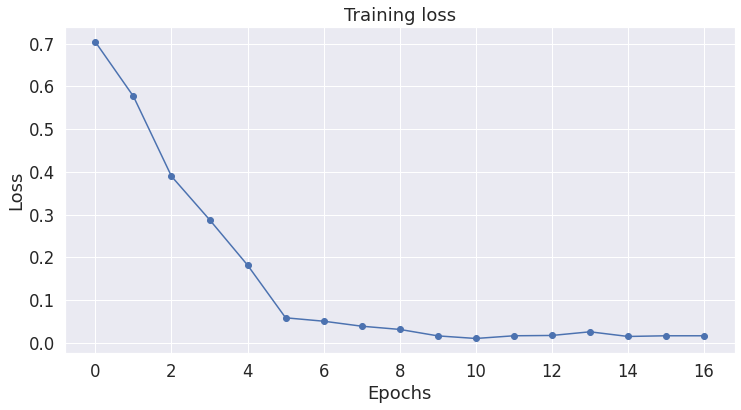

In [10]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

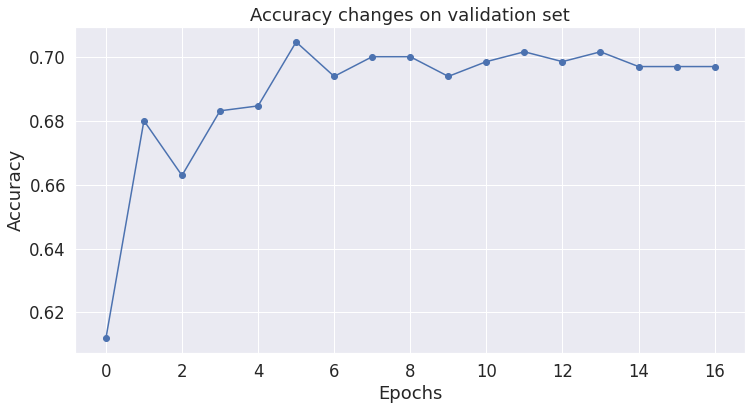

In [11]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(accuracy_values, 'b-o')

# Label the plot.
plt.title('Accuracy changes on validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

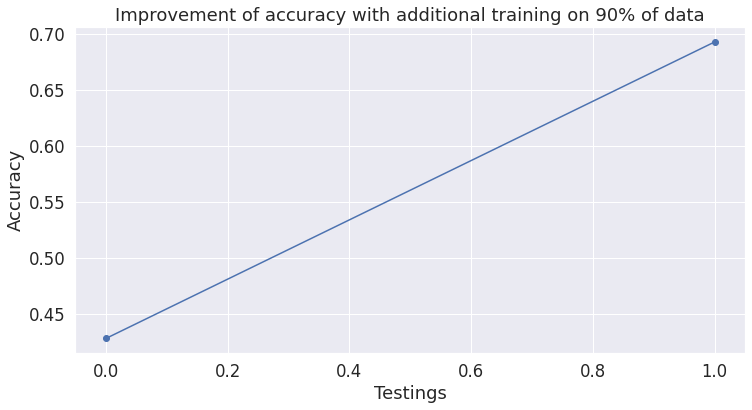

In [12]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(testing_accuracy_values, 'b-o')

# Label the plot.
plt.title('Improvement of accuracy with additional training on 90% of data')
plt.xlabel('Testings')
plt.ylabel('Accuracy')

plt.show()